## P.S. The main idea behind this notebook is inspired from FabienDaniel Kernel Elo_world.
https://www.kaggle.com/fabiendaniel/elo-world

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc
import pickle
from sklearn.base import BaseEstimator
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import log_loss
from sklearn.model_selection import RepeatedKFold
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# new_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv', parse_dates=['purchase_date'])
# historical_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv', parse_dates=['purchase_date'])

historical_transactions = pd.read_parquet('../input/hist_trans_df.parquet.gzip')
new_transactions = pd.read_parquet('../input/new_trans_df.parquet.gzip')

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [4]:
def add_new_merch_feat(df, merch_df):
#     df = pd.merge(left=df,
#                   right=merch_df[['merchant_id', 'merchant_group_id', 'category_4']],
#                   on=['merchant_id'],
#                   how='left')
    df['year'] = df['purchase_date'].dt.year.astype('category')
    df['month'] = df['purchase_date'].dt.month.astype('category')
    df['dow'] = df['purchase_date'].dt.dayofweek.astype('category')
    df['hour'] = df['purchase_date'].dt.hour
    df['day_part'] = 'Morning'
    df.loc[(df['hour'] > 12) & (df['hour'] <= 18), 'day_part'] = 'Afternoon'
    df.loc[(df['hour'] > 18) & (df['hour'] <= 24), 'day_part'] = 'Evening'
    # df['installments_flag'] = np.where(df['installments'] > 1, 'Y', 'N')
    
    # convert into proper data types
    df['hour'] = df['hour'].astype('category')
    df['day_part'] = df['day_part'].astype('category')
    # df['installments_flag'] = hist_trans_df['installments_flag'].astype('category')
    # df['dummy'] = 1
    # df.head(5)
    
    return df

In [5]:
%%time
merch_df = pd.read_parquet('../input/merch_df.parquet.gzip')

historical_transactions = add_new_merch_feat(historical_transactions, merch_df)
new_transactions = add_new_merch_feat(new_transactions, merch_df)

del merch_df
gc.collect()

CPU times: user 10.3 s, sys: 3.61 s, total: 13.9 s
Wall time: 13.9 s


In [6]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,month,dow,hour,day_part
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,6,15,Afternoon
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,5,12,Morning
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,2,22,Evening
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,9,5,10,Morning
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,3,4,1,Morning


In [7]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,month,dow,hour,day_part
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19,2018,3,6,14,Afternoon
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19,2018,3,0,18,Afternoon
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14,2018,4,3,14,Afternoon
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8,2018,3,2,9,Morning
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29,2018,3,3,21,Evening


In [8]:
# feat_list = ["city_id", "installments", "merchant_category_id", "month_lag", "state_id", "subsector_id"]
# for feat in feat_list:
#     print(feat + ":")
#     print(historical_transactions[feat].unique())

In [9]:
# feat_list = ["city_id", "installments", "merchant_category_id", "month_lag", "state_id", "subsector_id"]
# for feat in feat_list:
#     print(feat + ":")
#     print(len(historical_transactions[historical_transactions[feat] == -1])/len(historical_transactions)*100)

In [10]:
%%time
# def read_data(input_file):
#     df = pd.read_csv(input_file)
#     df['first_active_month'] = pd.to_datetime(df['first_active_month'])
#     df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
#     return df

# train = read_data('../input/elo-merchant-category-recommendation/train.csv')
# test = read_data('../input/elo-merchant-category-recommendation/test.csv')

def read_data_v2(input_file):
    df = pd.read_parquet(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data_v2('../input/train_df.parquet.gzip')
test = read_data_v2('../input/test_df.parquet.gzip')

target = train['target']
del train['target']
gc.collect()

CPU times: user 776 ms, sys: 23.9 ms, total: 800 ms
Wall time: 799 ms


## **Feature Engineering**

In [11]:
plot_opt = 0

In [12]:
historical_transactions["category_1"] += 1
historical_transactions["category_1"].unique()

array([1, 2])

In [13]:
new_transactions["category_1"] += 1
new_transactions["category_1"].unique()

array([1, 2])

In [14]:
historical_transactions["category_2"].unique()

array([ 1., nan,  3.,  5.,  2.,  4.])

In [15]:
historical_transactions["category_2"] = historical_transactions["category_2"].fillna(0)
historical_transactions["category_2"].unique()

array([1., 0., 3., 5., 2., 4.])

In [16]:
new_transactions["category_2"].unique()

array([ 1., nan,  3.,  2.,  4.,  5.])

In [17]:
new_transactions["category_2"] = new_transactions["category_2"].fillna(0)
new_transactions["category_2"].unique()

array([1., 0., 3., 2., 4., 5.])

In [18]:
historical_transactions["category_3"].unique()

array(['A', 'B', 'C', None], dtype=object)

In [19]:
historical_transactions["category_3"] = historical_transactions["category_3"].replace({'A': 1, 'B': 2, 'C': 3, None: 0})
historical_transactions["category_3"].unique()

array([1, 2, 3, 0])

In [20]:
new_transactions["category_3"].unique()

array(['B', None, 'C', 'A'], dtype=object)

In [21]:
new_transactions["category_3"] = new_transactions["category_3"].replace({'A': 1, 'B': 2, 'C': 3, None: 0})
new_transactions["category_3"].unique()

array([2, 0, 3, 1])

In [22]:
# historical_transactions["category_1_2_cross"] = historical_transactions["category_1"]*2 + historical_transactions["category_2"]
# np.sort(historical_transactions["category_1_2_cross"].unique())

In [23]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_1"], new_transactions["category_2"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_2")
#     plt.show()

In [24]:
# new_transactions["category_1_2_cross"] = new_transactions["category_1"]*2 + new_transactions["category_2"]
# np.sort(new_transactions["category_1_2_cross"].unique())

In [25]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_1"]+2, historical_transactions["category_3"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_3")
#     plt.show()

In [26]:
# historical_transactions["category_1_3_cross"] = (historical_transactions["category_1"]+2) * historical_transactions["category_3"]
# np.sort(historical_transactions["category_1_3_cross"].unique())

In [27]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_1"], new_transactions["category_3"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_3")
#     plt.show()

In [28]:
# new_transactions["category_1_3_cross"] = (new_transactions["category_1"]+2) * new_transactions["category_3"]
# np.sort(new_transactions["category_1_3_cross"].unique())

In [29]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_2"]+6, historical_transactions["category_3"])
#     plt.xlabel("category_2")
#     plt.ylabel("category_3")
#     plt.show()

In [30]:
# historical_transactions["category_2_3_cross"] = (historical_transactions["category_2"]+6) * historical_transactions["category_3"]
# np.sort(historical_transactions["category_2_3_cross"].unique())

In [31]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_2"]+6, new_transactions["category_3"])
#     plt.xlabel("category_2")
#     plt.ylabel("category_3")
#     plt.show()

In [32]:
# new_transactions["category_2_3_cross"] = (new_transactions["category_2"]+6) * new_transactions["category_3"]
# np.sort(new_transactions["category_2_3_cross"].unique())

In [33]:
%%time

def category_make_cross_feat(df):
    df["category_1_3_cross"] = (df["category_1"]+2) * df["category_3"]
    df["category_2_3_cross"] = (df["category_2"]+6) * df["category_3"]
    return df

historical_transactions = category_make_cross_feat(historical_transactions)
new_transactions = category_make_cross_feat(new_transactions)

CPU times: user 236 ms, sys: 260 ms, total: 497 ms
Wall time: 496 ms


In [34]:
%%time
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 
                                                                           'category_3',
                                                                           'category_1_3_cross',
                                                                           'category_2_3_cross'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 
                                                             'category_3',
                                                             'category_1_3_cross',
                                                             'category_2_3_cross'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean', 'min', 'std', 'count']} # max is all 1's, useless
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]
gc.collect()

Mem. usage decreased to 2193.33 Mb (41.9% reduction)
Mem. usage decreased to 144.15 Mb (43.4% reduction)
CPU times: user 15.6 s, sys: 7.44 s, total: 23.1 s
Wall time: 23.1 s


In [35]:
auth_mean.head()

,card_id,authorized_flag_sum,authorized_flag_mean,authorized_flag_min,authorized_flag_std,authorized_flag_count
0,C_ID_00007093c1,114.0,0.765101,0,0.425366,149
1,C_ID_0001238066,120.0,0.975610,0,0.154888,123
2,C_ID_0001506ef0,62.0,0.939394,0,0.240435,66
3,C_ID_0001793786,189.0,0.875000,0,0.331487,216
4,C_ID_000183fdda,137.0,0.951389,0,0.215804,144


In [36]:
%%time
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month
gc.collect()

CPU times: user 975 ms, sys: 68.2 ms, total: 1.04 s
Wall time: 1.04 s


In [37]:
%%time
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_1': ['mean'],
        'category_3_2': ['mean'],
        'category_3_3': ['mean'],
        'category_1_3_cross_3': ['mean'],
        'category_1_3_cross_4': ['mean'],
        'category_1_3_cross_6': ['mean'],
        'category_1_3_cross_8': ['mean'],
        'category_1_3_cross_9': ['mean'],
        'category_1_3_cross_12': ['mean'],
        'category_2_3_cross_7.0': ['mean'],
        'category_2_3_cross_8.0': ['mean'],
        'category_2_3_cross_9.0': ['mean'],
        'category_2_3_cross_10.0': ['mean'],
        'category_2_3_cross_11.0': ['mean'],
        'category_2_3_cross_12.0': ['mean'],
        'category_2_3_cross_14.0': ['mean'],
        'category_2_3_cross_16.0': ['mean'],
        'category_2_3_cross_20.0': ['mean'],
        'category_2_3_cross_21.0': ['mean'],
        'category_2_3_cross_22.0': ['mean'],
        'category_2_3_cross_24.0': ['mean'],
        'category_2_3_cross_27.0': ['mean'],
        'category_2_3_cross_30.0': ['mean'],
        'category_2_3_cross_33.0': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std', 'count', 'median'], #one count is enough, others are just the same
        'installments': ['sum', 'mean', 'max', 'min', 'std', 'median'],
        'purchase_month': ['mean', 'max', 'min', 'std', 'median'],
        'purchase_date': [np.ptp, 'min', 'max', 'median'],
        'month_lag': ['min', 'max', 'median']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

gc.collect()

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 27.9 ms


In [38]:
%%time
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]
gc.collect()

CPU times: user 25.6 s, sys: 382 ms, total: 26 s
Wall time: 25.9 s


In [39]:
# # history[["hist_purchase_amount_count", "hist_installments_count", "hist_purchase_month_count"]].head(500)
history.head(10)

,card_id,hist_transactions_count,hist_category_1_3_cross_12_mean,hist_category_1_3_cross_9_mean,hist_category_2_3_cross_9.0_mean,hist_category_2_3_cross_10.0_mean,hist_merchant_id_nunique,hist_category_2_3_cross_14.0_mean,hist_category_2_5.0_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_count,hist_purchase_amount_median,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_month_median,hist_merchant_category_id_nunique,hist_category_2_1.0_mean,hist_category_2_3_cross_8.0_mean,hist_category_2_3_cross_30.0_mean,hist_subsector_id_nunique,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_installments_median,hist_category_2_3_cross_21.0_mean,hist_city_id_nunique,hist_category_2_3_cross_16.0_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_3_cross_24.0_mean,hist_category_1_3_cross_6_mean,hist_category_2_3_cross_11.0_mean,hist_category_2_3.0_mean,hist_state_id_nunique,hist_category_2_3_cross_12.0_mean,hist_category_1_3_cross_3_mean,hist_category_1_3_cross_8_mean,hist_category_2_3_cross_20.0_mean,hist_category_2_3_cross_33.0_mean,hist_category_1_3_cross_4_mean,hist_category_2_2.0_mean,hist_category_2_3_cross_22.0_mean,hist_category_2_3_cross_27.0_mean,hist_month_lag_min,hist_month_lag_max,hist_month_lag_median,hist_category_3_1_mean,hist_category_2_3_cross_7.0_mean,hist_category_2_4.0_mean,hist_category_3_2_mean,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_median,hist_category_3_3_mean
0,C_ID_00007093c1,35,0.0,0.171429,0.000000,0.0,11,0.000000,0.000000,-14.401965,-0.411485,1.507069,-0.728876,0.430059,35,-0.569219,5.914286,12,1,3.071419,6.0,8,0.000000,0.000000,0.0,7,45,1.285714,3,1,0.667367,1.0,0.0,3,0.000000,39.0,1.114286,0.000000,0.714286,0.0,0.885714,2,0.114286,0.000000,0.114286,0.0,0.0,0.0,0.000000,0.000000,0.171429,-11,0,-7.0,0.000000,0.000000,0.0,0.828571,28858113.0,1.489250e+09,1.518108e+09,1.501537e+09,0.171429
1,C_ID_0001238066,3,0.0,0.000000,0.000000,0.0,2,0.333333,0.666667,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,-0.596643,8.666667,12,2,5.773503,12.0,1,0.333333,0.000000,0.0,1,3,1.000000,1,1,0.000000,1.0,0.0,2,0.000000,3.0,1.000000,0.000000,1.000000,0.0,0.000000,2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.666667,0.000000,-2,0,-2.0,0.000000,0.000000,0.0,1.000000,3609150.0,1.514660e+09,1.518269e+09,1.514660e+09,0.000000
2,C_ID_0001506ef0,4,0.0,0.000000,0.750000,0.0,4,0.000000,0.000000,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,4,-0.728350,5.500000,12,2,4.725816,4.0,4,0.000000,0.000000,0.0,4,1,0.250000,1,0,0.500000,0.0,0.0,1,0.000000,4.0,1.000000,0.000000,0.250000,0.0,1.000000,1,0.000000,0.750000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-8,0,-1.0,0.750000,0.000000,0.0,0.250000,22098875.0,1.496772e+09,1.518871e+09,1.515497e+09,0.000000
3,C_ID_0001793786,27,0.0,0.000000,0.111111,0.0,17,0.037037,0.000000,-11.825338,-0.437975,1.236592,-0.745405,0.498150,27,-0.566620,6.481481,9,3,2.375684,7.0,14,0.111111,0.296296,0.0,11,5,0.185185,1,0,0.395847,0.0,0.0,8,0.000000,29.0,1.074074,0.000000,0.111111,0.0,0.111111,4,0.148148,0.814815,0.074074,0.0,0.0,0.0,0.296296,0.000000,0.000000,-7,-1,-3.0,0.814815,0.074074,0.0,0.185185,16780236.0,1.488636e+09,1.505416e+09,1.500928e+09,0.000000
4,C_ID_000183fdda,7,0.0,0.571429,0.000000,0.0,4,0.000000,0.000000,-0.941381,-0.134483,0.334099,-0.714541,0.452741,7,-0.339389,8.285714,10,8,0.755929,8.0,4,0.000000,0.000000,0.0,4,19,2.714286,6,1,2.288689,2.0,0.0,1,0.000000,7.0,1.000000,0.000000,0.428571,0.0,1.000000,1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.571429,-6,-4,-6.0,0.000000,0.000000,0.0,0.428571,6701589.0,1.502099e+09,1.508801e+09,1.504164e+09,0.571429
5,C_ID_00024e244b,17,0.0,0.000000,0.705882,0.0,7,0.000000,0.000000,-8.306611,-0.488624,0.548543,-0.724593,0.415206,17,-0.700326

In [40]:
%%time
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]
gc.collect()

CPU times: user 1min 25s, sys: 6.64 s, total: 1min 32s
Wall time: 1min 32s


In [41]:
%%time
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]
gc.collect()

CPU times: user 26.6 s, sys: 313 ms, total: 26.9 s
Wall time: 26.9 s


In [42]:
%%time
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
#             'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
#             'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'purchase_amount': ['count', 'sum'],
            'installments': ['count', 'sum'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]
gc.collect()

CPU times: user 1.63 s, sys: 75.7 ms, total: 1.7 s
Wall time: 1.7 s


In [43]:
%%time
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
gc.collect()

Train Shape: (201917, 207)
Test Shape: (123623, 207)
CPU times: user 2.23 s, sys: 456 ms, total: 2.68 s
Wall time: 2.68 s


In [44]:
def generate_feat(df):
    # Feature crosses
    df["feature_1_2_cross"] = df["feature_1"] + (df["feature_2"]-1)*5
    df["feature_1_3_cross"] = df["feature_1"] + df["feature_3"]*3
    df["feature_2_3_cross"] = df["feature_2"] + df["feature_3"]*3
    df = pd.get_dummies(df, columns=["feature_1_2_cross", "feature_1_3_cross", "feature_2_3_cross"])
    
    return df

train = generate_feat(train)
test = generate_feat(test)

In [45]:
def power_2_3_feat(df, feat_list):
    for feat in feat_list:
        df[feat+"_power2"] = df[feat]**2
#         df[feat+"_power3"] = df[feat]**3
    return df

feat_list = ["elapsed_time", "hist_purchase_date_ptp"]
train = power_2_3_feat(train, feat_list)
test = power_2_3_feat(test, feat_list)

In [46]:
def log_feat(df, feat_list):
    for feat in feat_list:
        df[feat+"_log"] = np.log(df[feat])
#         df[feat+"_power3"] = df[feat]**3
    return df

feat_list = ["elapsed_time"]
train = log_feat(train, feat_list)
test = log_feat(test, feat_list)

/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
corrmat = train.corr()

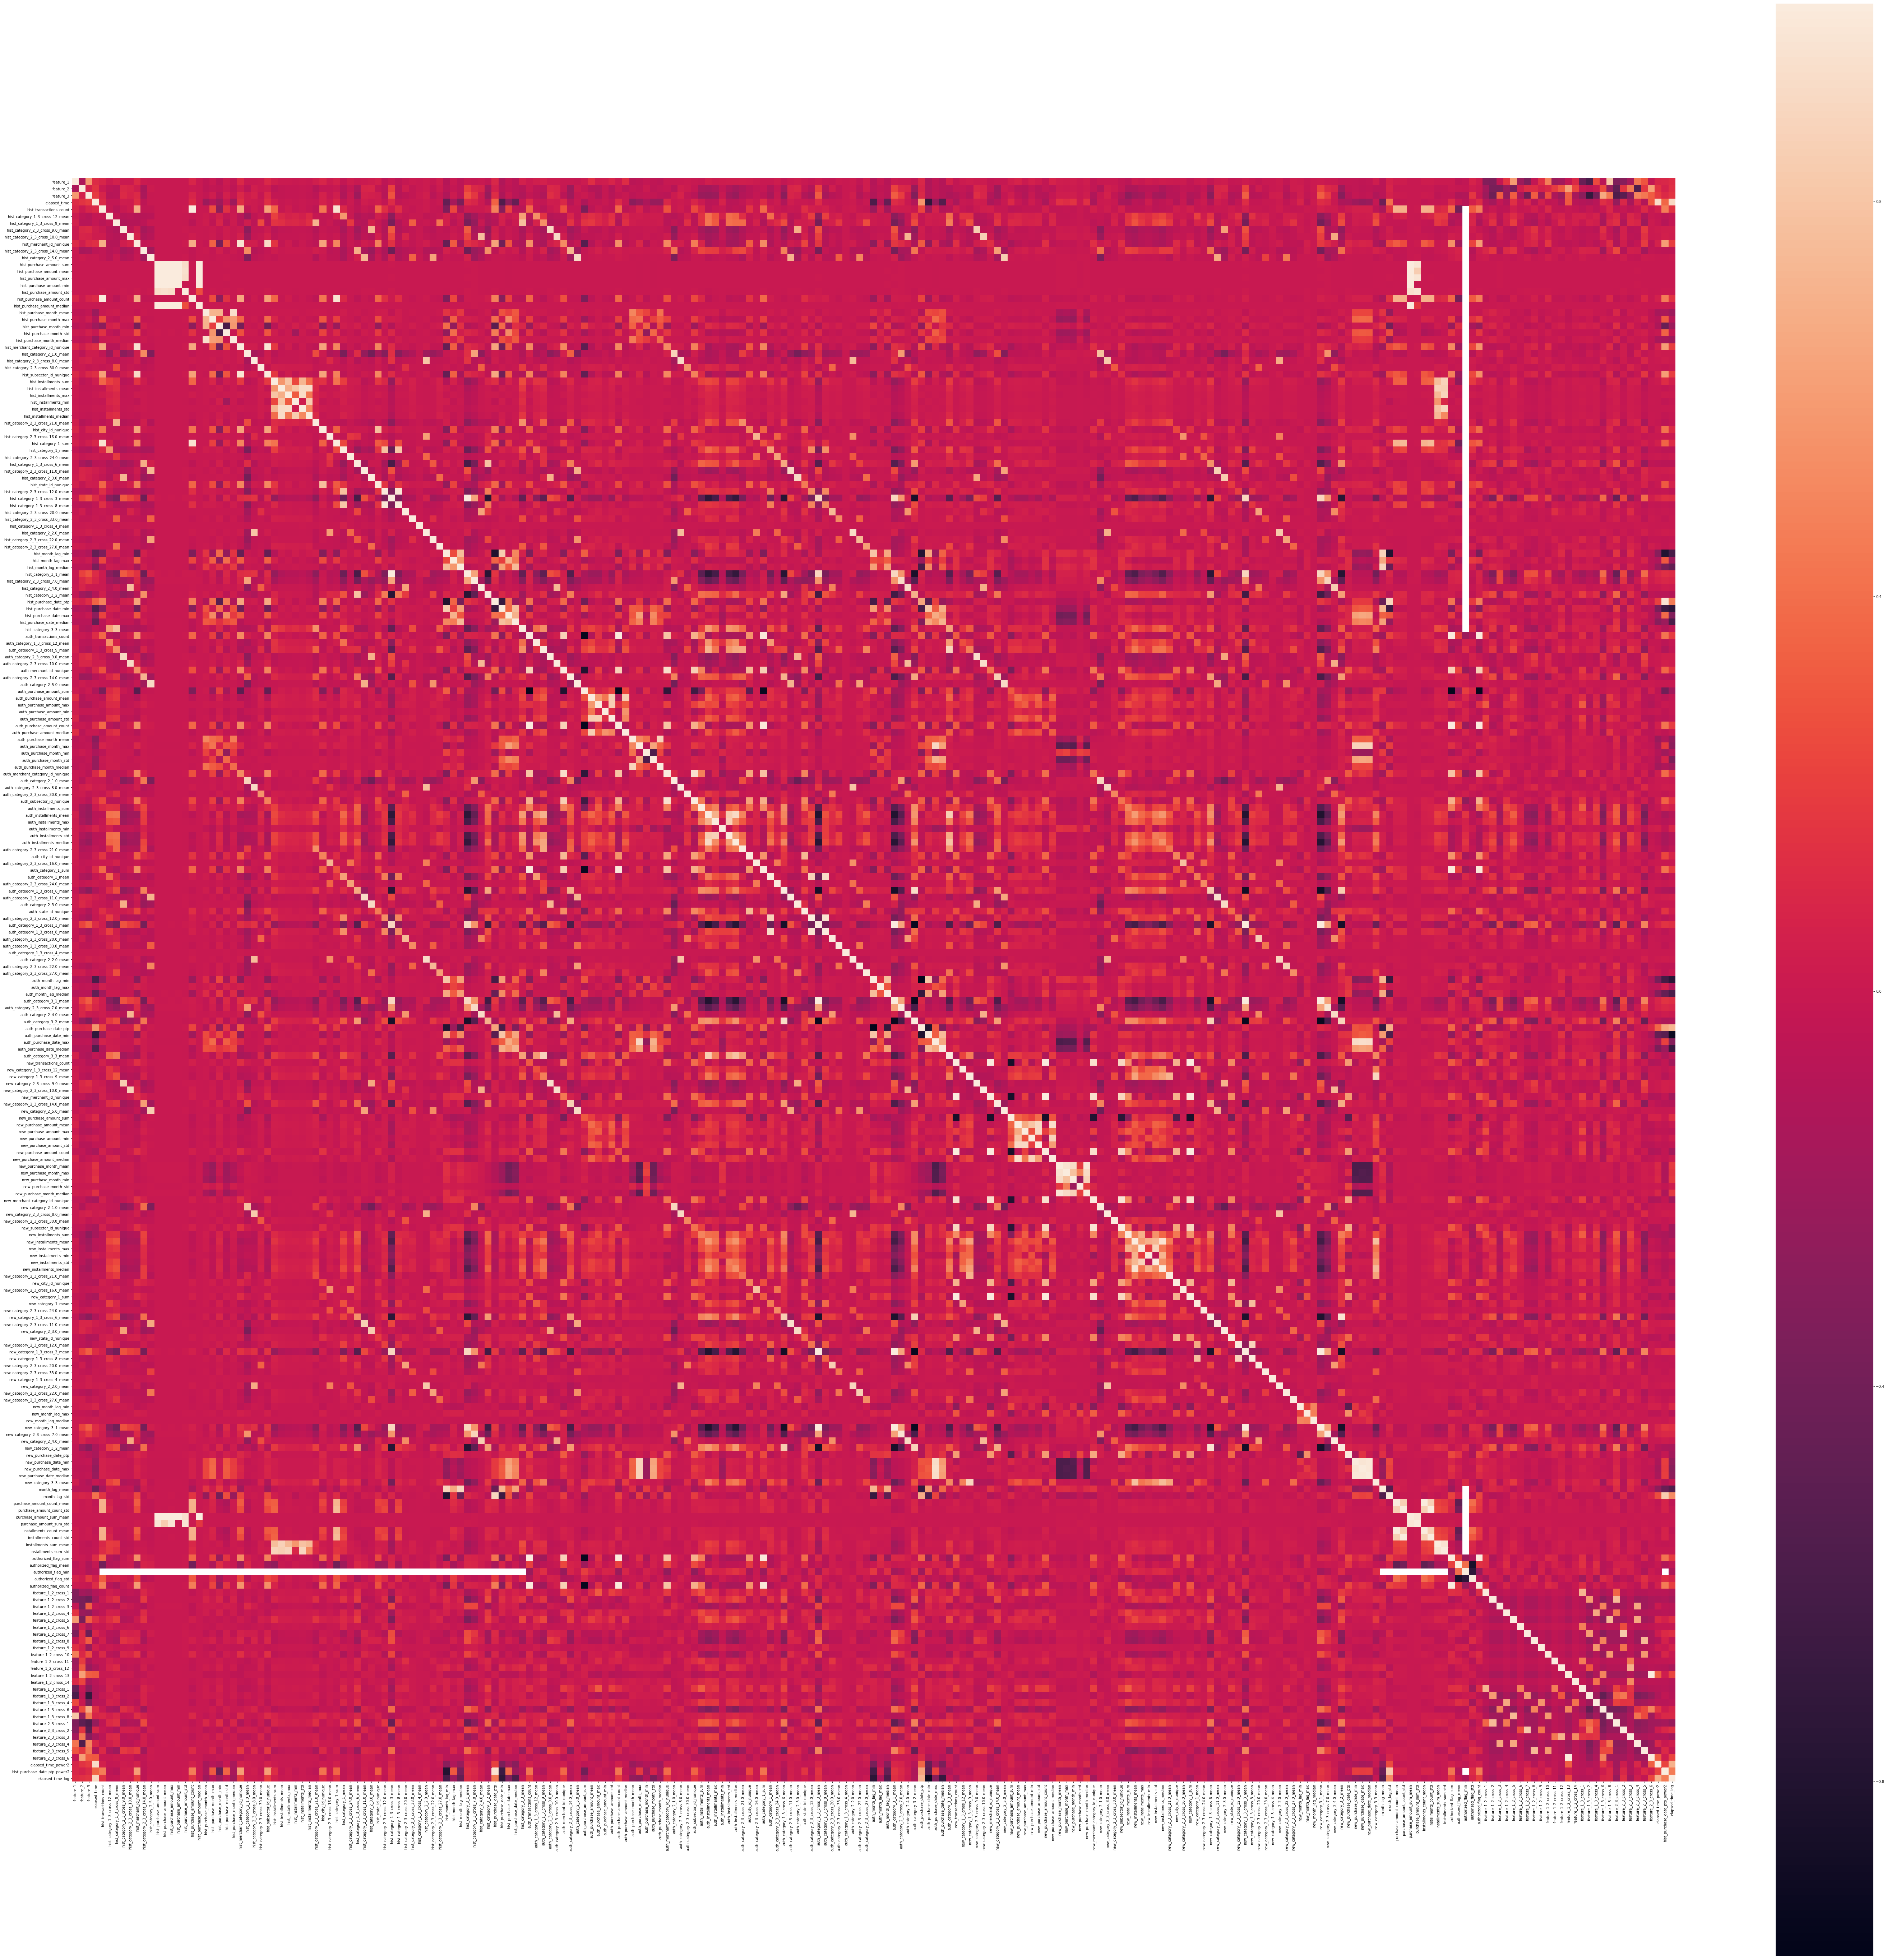

In [48]:
f, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(corrmat, vmax=1.0, square=True)

In [49]:
f.savefig("../img/corr.png")

In [50]:
remove_feat_list = ['authorized_flag_min', 
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_std',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_std',
                    'hist_installments_median',
                    'hist_purchase_amount_median',
                    'new_purchase_month_max',
                    'new_purchase_month_min',
                    'new_purchase_month_median',
                    'new_purchase_date_min',
                    'new_purchase_date_max',
                    'installments_count_std',
                    'installments_sum_std',
                    'purchase_amount_sum_std',
                    'hist_purchase_month_max',
                    'hist_purchase_month_min',
                    'auth_installments_sum',
                    'auth_installments_median',
                    'auth_category_1_3_cross_6_mean',
                    'new_installments_sum',
                    'new_installments_median',
                    'new_purchase_amount_max',
                    'new_purchase_amount_min',
                    'new_purchase_amount_std'
                   ]
train = train.drop(remove_feat_list, axis=1)
test = test.drop(remove_feat_list, axis=1)

In [51]:
corrmat = train.corr()

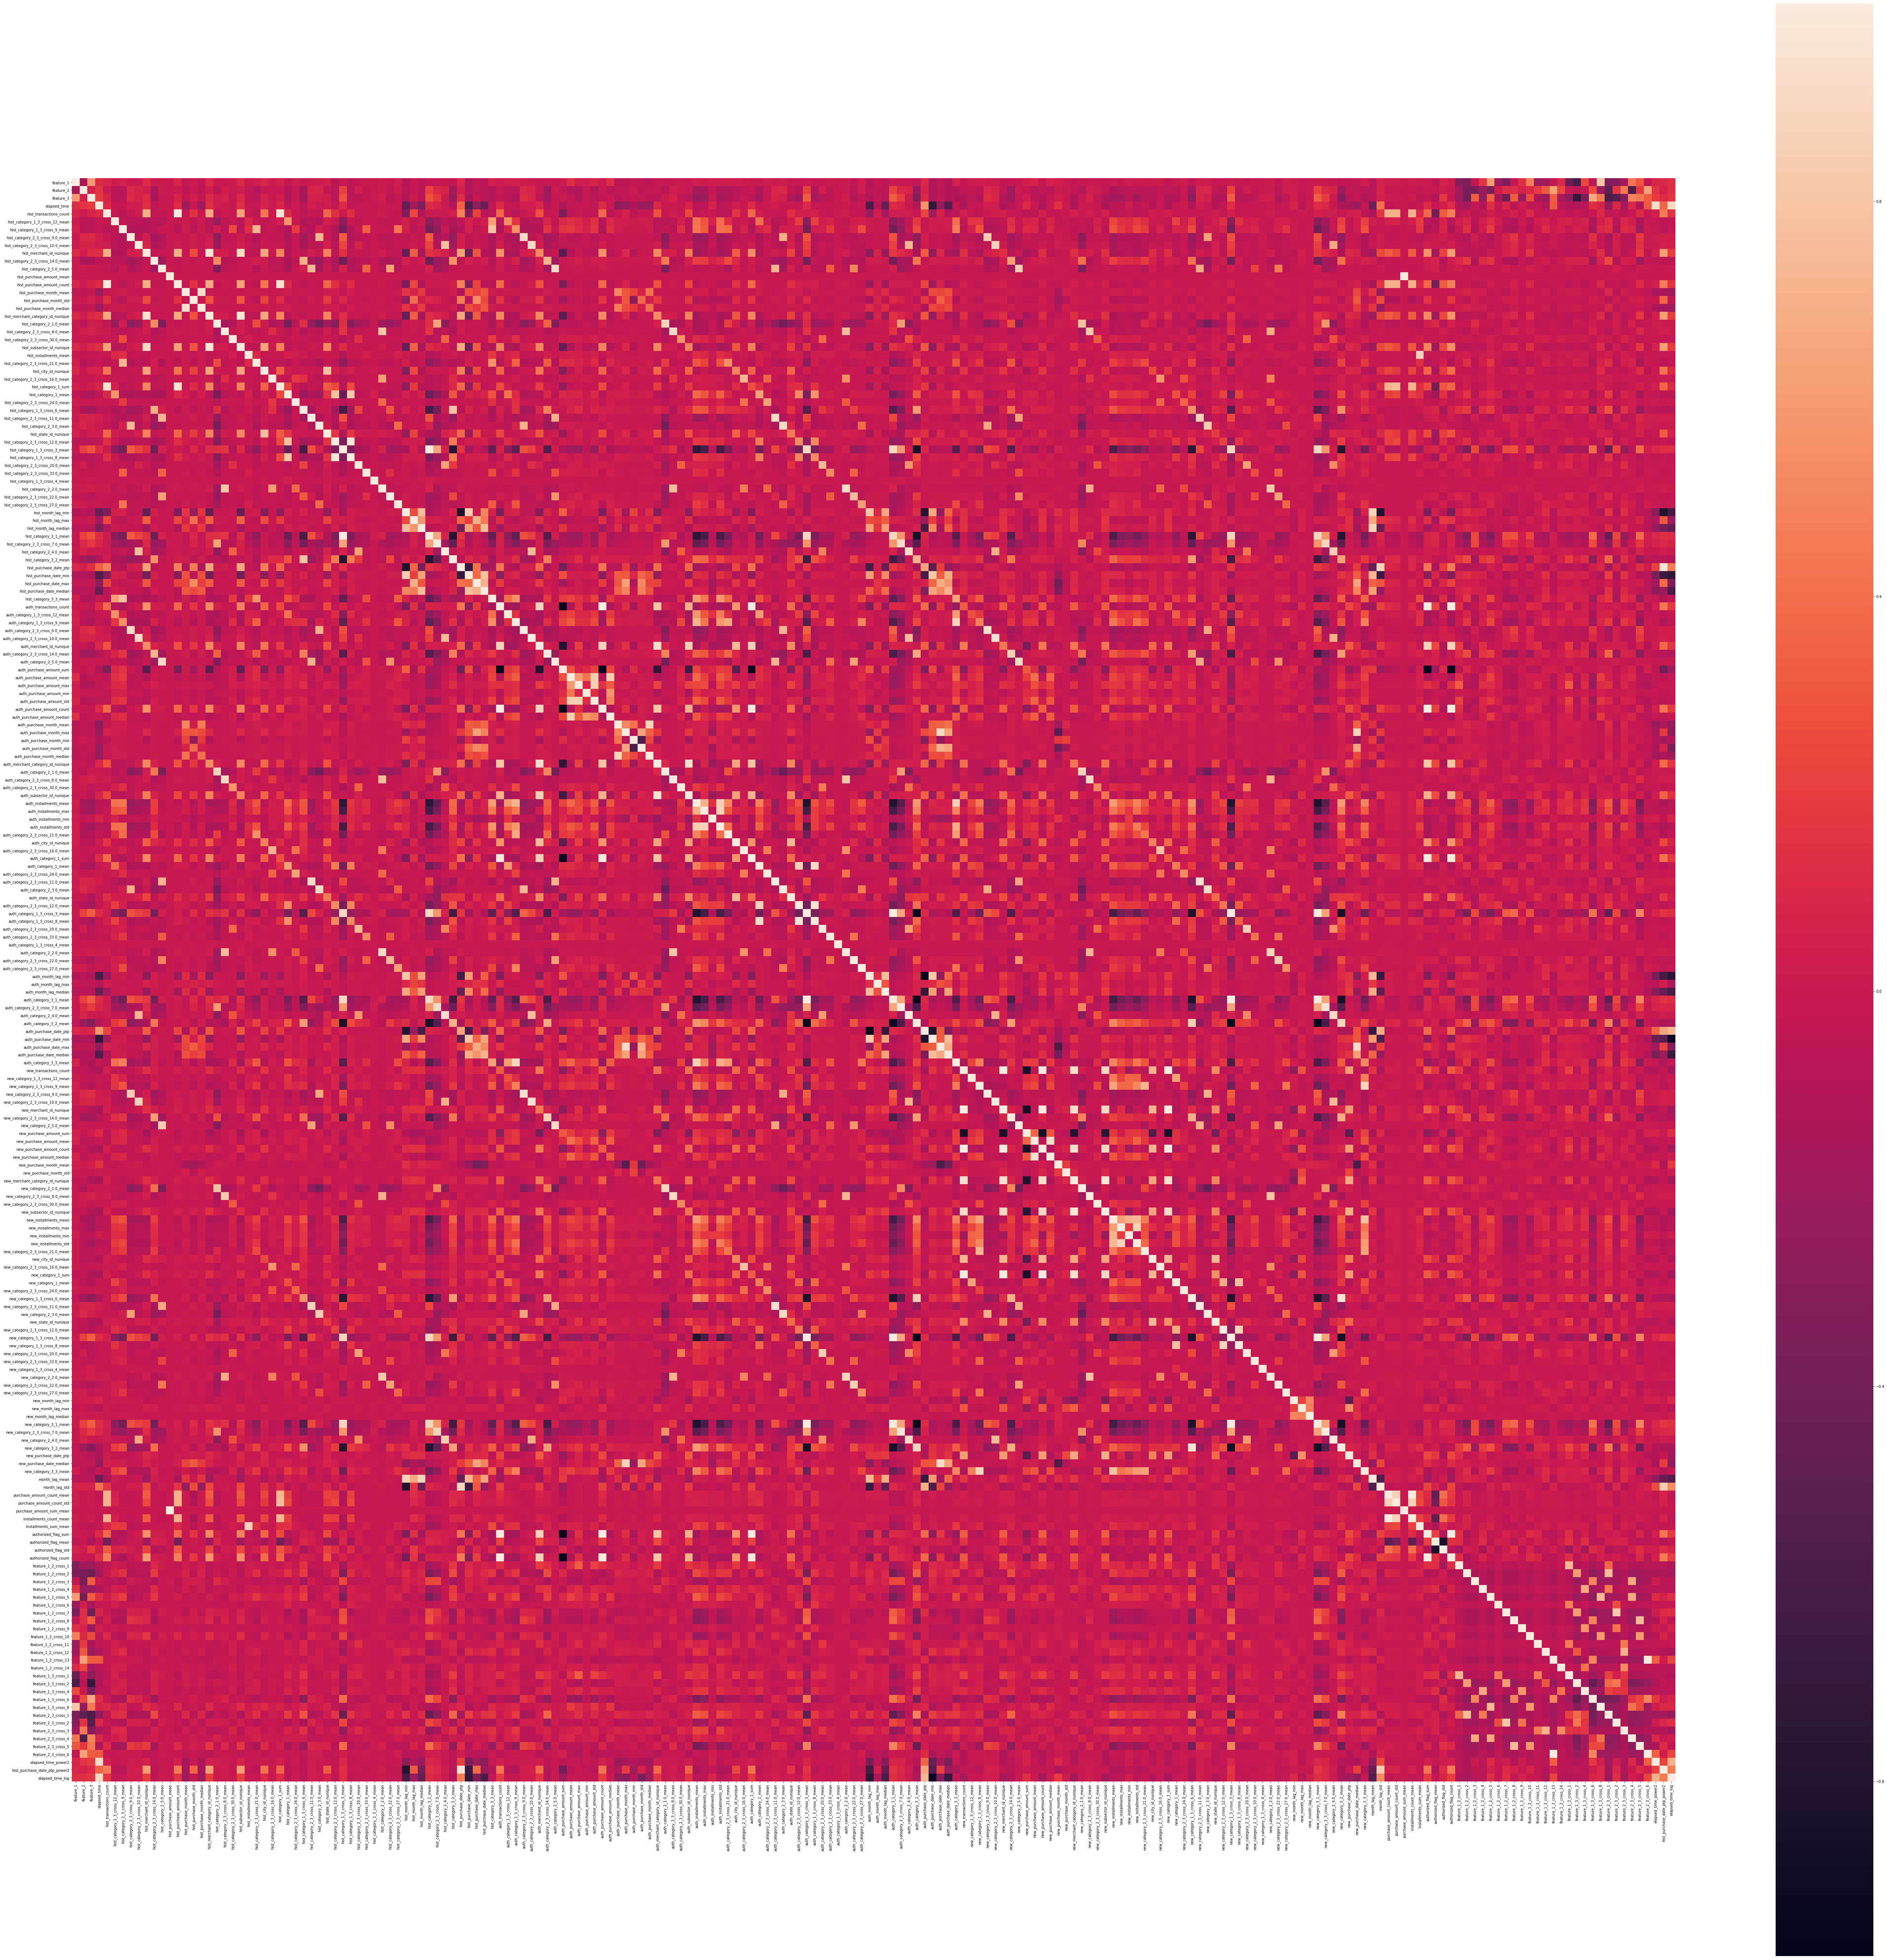

In [52]:
f, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(corrmat, vmax=1.0, square=True)

In [53]:
f.savefig("../img/corr_after_feat_removal.png")

In [ ]:
# with open('../input/feat_list.pkl', 'rb') as f:
#     feat_list = pickle.load(f)

# train = train[feat_list]
# test = test[feat_list]

In [55]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_3_cross_12_mean,hist_category_1_3_cross_9_mean,hist_category_2_3_cross_9.0_mean,hist_category_2_3_cross_10.0_mean,hist_merchant_id_nunique,hist_category_2_3_cross_14.0_mean,hist_category_2_5.0_mean,hist_purchase_amount_mean,hist_purchase_amount_count,hist_purchase_month_mean,hist_purchase_month_std,hist_purchase_month_median,hist_merchant_category_id_nunique,hist_category_2_1.0_mean,hist_category_2_3_cross_8.0_mean,hist_category_2_3_cross_30.0_mean,hist_subsector_id_nunique,hist_installments_mean,hist_category_2_3_cross_21.0_mean,hist_city_id_nunique,hist_category_2_3_cross_16.0_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_3_cross_24.0_mean,hist_category_1_3_cross_6_mean,hist_category_2_3_cross_11.0_mean,hist_category_2_3.0_mean,hist_state_id_nunique,hist_category_2_3_cross_12.0_mean,hist_category_1_3_cross_3_mean,hist_category_1_3_cross_8_mean,hist_category_2_3_cross_20.0_mean,hist_category_2_3_cross_33.0_mean,hist_category_1_3_cross_4_mean,hist_category_2_2.0_mean,hist_category_2_3_cross_22.0_mean,hist_category_2_3_cross_27.0_mean,hist_month_lag_min,hist_month_lag_max,hist_month_lag_median,hist_category_3_1_mean,hist_category_2_3_cross_7.0_mean,hist_category_2_4.0_mean,hist_category_3_2_mean,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_median,hist_category_3_3_mean,auth_transactions_count,auth_category_1_3_cross_12_mean,auth_category_1_3_cross_9_mean,auth_category_2_3_cross_9.0_mean,auth_category_2_3_cross_10.0_mean,auth_merchant_id_nunique,auth_category_2_3_cross_14.0_mean,auth_category_2_5.0_mean,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_count,auth_purchase_amount_median,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_median,auth_merchant_category_id_nunique,auth_category_2_1.0_mean,auth_category_2_3_cross_8.0_mean,auth_category_2_3_cross_30.0_mean,auth_subsector_id_nunique,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_category_2_3_cross_21.0_mean,auth_city_id_nunique,auth_category_2_3_cross_16.0_mean,auth_category_1_sum,auth_category_1_mean,auth_category_2_3_cross_24.0_mean,auth_category_2_3_cross_11.0_mean,auth_category_2_3.0_mean,auth_state_id_nunique,auth_category_2_3_cross_12.0_mean,auth_category_1_3_cross_3_mean,auth_category_1_3_cross_8_mean,auth_category_2_3_cross_20.0_mean,auth_category_2_3_cross_33.0_mean,auth_category_1_3_cross_4_mean,auth_category_2_2.0_mean,auth_category_2_3_cross_22.0_mean,auth_category_2_3_cross_27.0_mean,auth_month_lag_min,auth_month_lag_max,auth_month_lag_median,auth_category_3_1_mean,auth_category_2_3_cross_7.0_mean,auth_category_2_4.0_mean,auth_category_3_2_mean,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_date_median,auth_category_3_3_mean,new_transactions_count,new_category_1_3_cross_12_mean,new_category_1_3_cross_9_mean,new_category_2_3_cross_9.0_mean,new_category_2_3_cross_10.0_mean,new_merchant_id_nunique,new_category_2_3_cross_14.0_mean,new_category_2_5.0_mean,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_count,new_purchase_amount_median,new_purchase_month_mean,new_purchase_month_std,new_merchant_category_id_nunique,new_category_2_1.0_mean,new_category_2_3_cross_8.0_mean,new_category_2_3_cross_30.0_mean,new_subsector_id_nunique,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_category_2_3_cross_21.0_mean,new_city_id_nunique,new_category_2_3_cross_16.0_mean,new_category_1_sum,new_category_1_mean,new_category_2_3_cross_24.0_mean,new_category_1_3_cross_6_mean,new_category_2_3_cross_11.0_mean,new_category_2_3.0_mean,new_state_id_nunique,new_category_2_3_cross_12.0_mean,new_category_1_3_cross_3_mean,ne

#### check each feat distribution

In [62]:
train['dummy']=1
test['dummy']=1

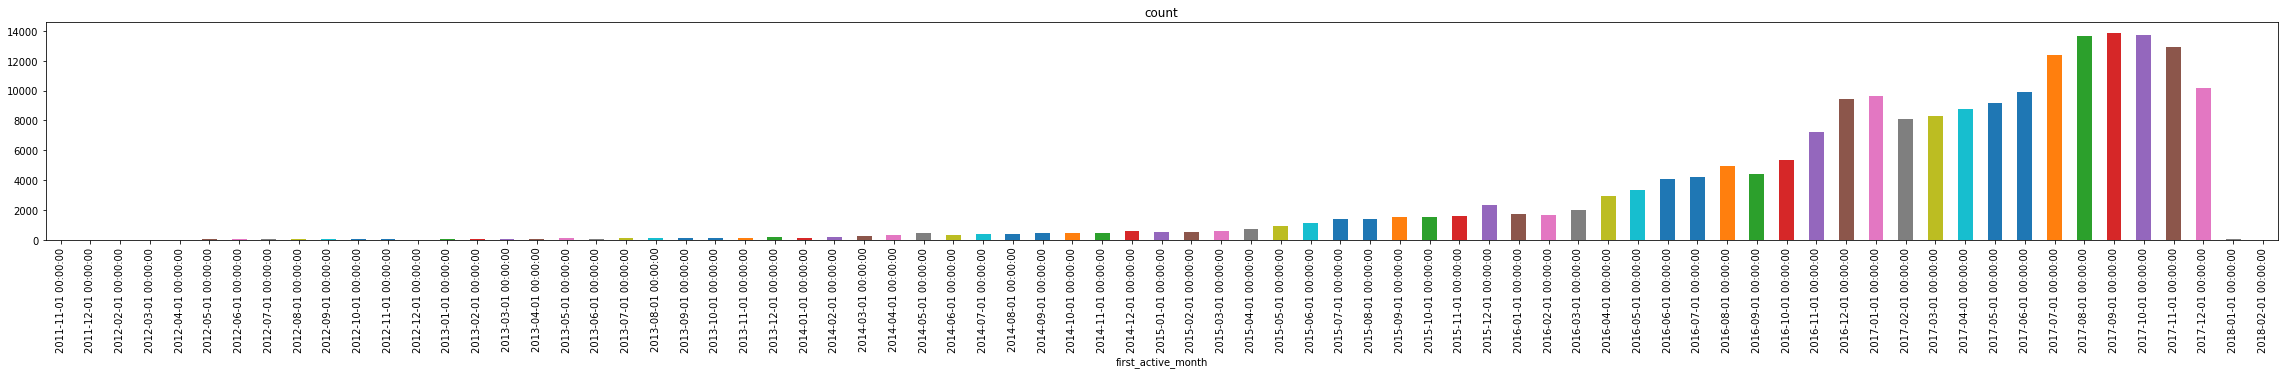

In [60]:
train.groupby('first_active_month').count()['dummy'].plot(kind='bar', title='count', figsize=(40,4))
plt.show()

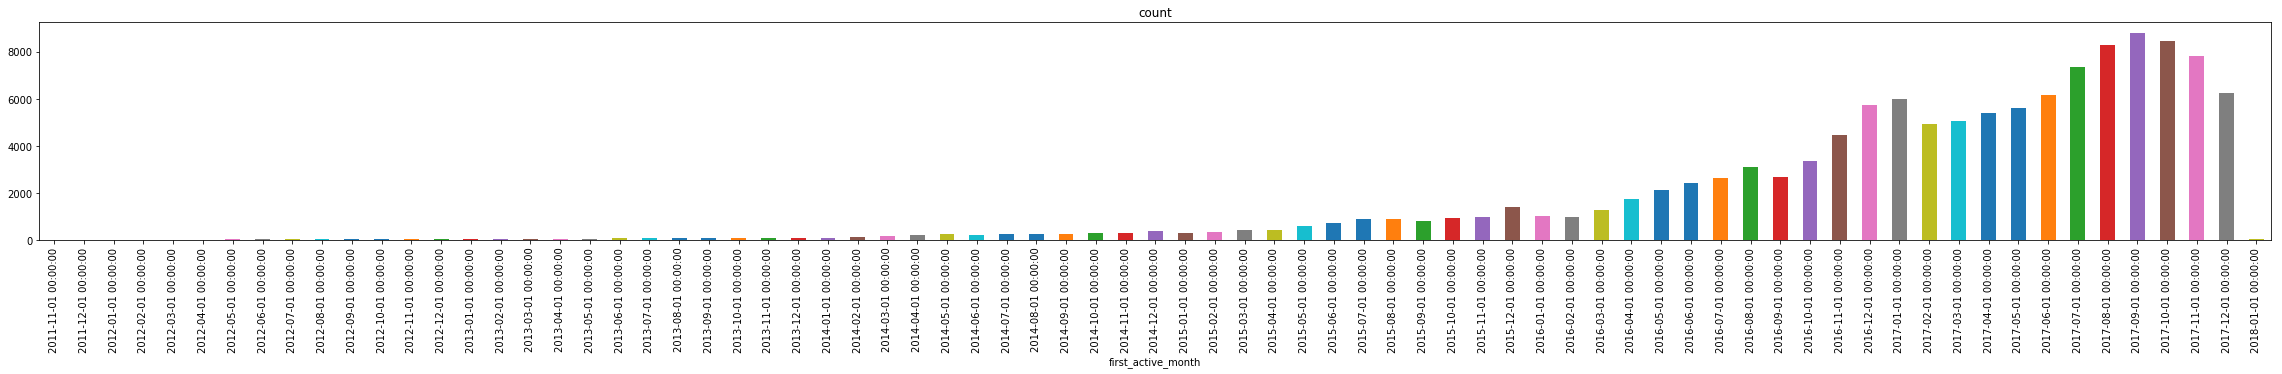

In [63]:
test.groupby('first_active_month').count()['dummy'].plot(kind='bar', title='count', figsize=(40,4))
plt.show()

In [70]:
list(train)

['first_active_month',
 'card_id',
 'feature_1',
 'feature_2',
 'feature_3',
 'elapsed_time',
 'hist_transactions_count',
 'hist_category_1_3_cross_12_mean',
 'hist_category_1_3_cross_9_mean',
 'hist_category_2_3_cross_9.0_mean',
 'hist_category_2_3_cross_10.0_mean',
 'hist_merchant_id_nunique',
 'hist_category_2_3_cross_14.0_mean',
 'hist_category_2_5.0_mean',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_count',
 'hist_purchase_month_mean',
 'hist_purchase_month_std',
 'hist_purchase_month_median',
 'hist_merchant_category_id_nunique',
 'hist_category_2_1.0_mean',
 'hist_category_2_3_cross_8.0_mean',
 'hist_category_2_3_cross_30.0_mean',
 'hist_subsector_id_nunique',
 'hist_installments_mean',
 'hist_category_2_3_cross_21.0_mean',
 'hist_city_id_nunique',
 'hist_category_2_3_cross_16.0_mean',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_category_2_3_cross_24.0_mean',
 'hist_category_1_3_cross_6_mean',
 'hist_category_2_3_cross_11.0_mean',
 'hist_category_2_3.0_mean'

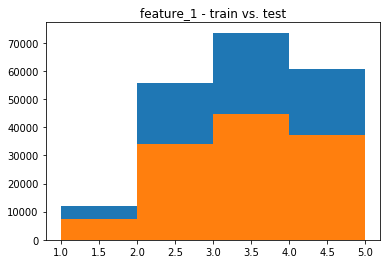

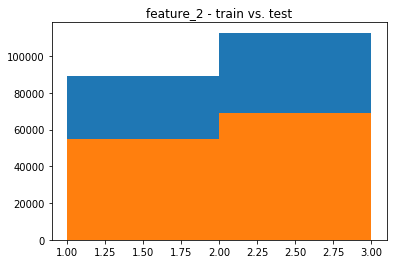

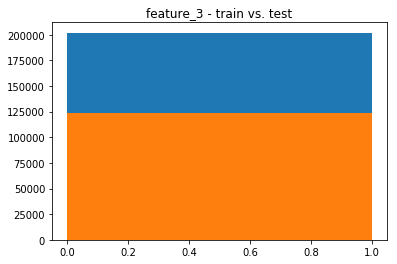

/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: range parameter must be finite.

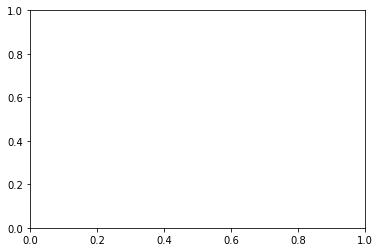

In [72]:
# plt.hist(test['first_active_month'])
# plt.title("Gaussian Histogram")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
feat_list = ['feature_1', 'feature_2', 'feature_3', ]
for feat in feat_list:
    plt.hist(train[feat], bins=np.arange(train[feat].min(), train[feat].max()+1), label='train')
    plt.hist(test[feat], bins=np.arange(test[feat].min(), test[feat].max()+1), label='test')
    plt.title(feat + ' - train vs. test')
    plt.show()

#### save train, test

In [73]:
with open('../input/train_test_target_v7.pkl', 'wb') as f:
    pickle.dump([train, target, test], f)

In [74]:
with open('../input/train_test_target_v7.pkl', 'rb') as f:
    [train, target, test] = pickle.load(f)

In [75]:
# https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
# saleprice correlation matrix

# k = train.shape[1] #number of variables for heatmap
# cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(df_train[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [76]:
# #scatterplot
# sns.set()
# # cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
# # sns.pairplot(df_train[cols], size = 2.5)
# sns.pairplot(train, size = 2.5)
# plt.show();

In [77]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

In [78]:
train = train.fillna(0)
test = test.fillna(0)

### Outlier removal

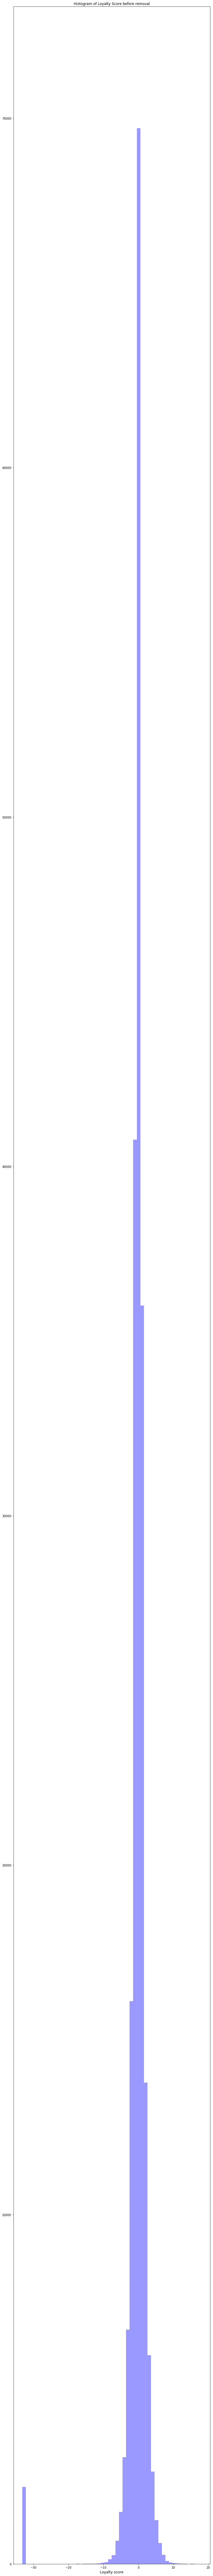

In [79]:
plt.figure(figsize=(12,160))
sns.distplot(target.values, bins=50, kde=False, color='blue')
plt.title('Histogram of Loyalty Score before removal')
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

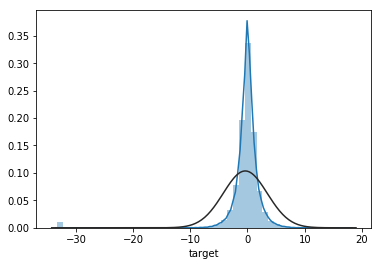

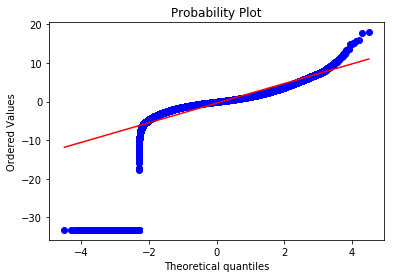

In [80]:
from scipy.stats import norm
from scipy import stats
sns.distplot(target, fit=norm)
fig = plt.figure()
res = stats.probplot(target, plot=plt)

In [81]:
#skewness and kurtosis
print("Skewness: %f" % pd.DataFrame(target).skew())
print("Kurtosis: %f" % pd.DataFrame(target).kurt())

Skewness: -6.720160
Kurtosis: 55.031783


In [82]:
min_target = min(value for value in target if value > -20)
min_target

-17.60814651

In [83]:
idx_between_20_30 = [value for value in target if value >= -30 and value <=-20]
len(idx_between_20_30)

0

In [84]:
idx_lessThan_30 = [value for value in target if value < -30]
len(idx_lessThan_30)

2207

In [85]:
# https://www.kaggle.com/nottold/naive-ensemble-model-ridge-lasso
class OutlierDetection(BaseEstimator):
    def __init__(self, alpha, dims, std, mean, median):
        self.alpha = alpha
        self.dims = dims
        self.std = std
        self.mean = mean
        self.median = median
    def fit(self, X):
        # std, mean, median = X.std(), X.mean(), X.median()
        X["outliers"] = 0
        for col in X.columns:
#             print(col)
            if not col == "outliers":
                # outlier_idx = (abs(X[col]) > (self.alpha * std[col] + mean[col]))
                outlier_idx = (np.abs(X[col]) > (self.alpha * self.std[col] + self.mean[col]))
                X.set_value(outlier_idx, "outliers", X[outlier_idx]["outliers"] + 1)
        outliers = X[X["outliers"] > self.dims]
        X.drop("outliers", axis=1, inplace=True)
        outlier_idx = outliers.index.tolist()
        # return outliers.index
        return set(list(range(X.shape[0]))) - set(outlier_idx), outlier_idx

In [86]:
target_df = pd.DataFrame(target)

outlier_removal = OutlierDetection(alpha=3, 
                                   dims=0, 
                                   std=target_df.std().astype('float'), 
                                   mean=target_df.mean().astype('float'), 
                                   median=target_df.median().astype('float'))
normal_idx, outlier_idx = outlier_removal.fit(target_df)
# samples = target_df.shape[0] - len(outlier)
# xtrain = xtrain.drop(outlier_index).reset_index(drop=True)
# y = y.drop(outlier_index).reset_index(drop=True)

In [87]:
train["outliers"] = 0
train.at[outlier_idx, "outliers"] = 1

In [88]:
train["outliers"].unique()

array([0, 1])

In [89]:
with open('../input/train_test_target_with_target.pkl', 'wb') as f:
    pickle.dump([train, target, test, normal_idx, outlier_idx], f)

In [90]:
with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)

## Step 1: Training Model Without Outliers for 5 fold (n_repeats = 1)

In [91]:
df_train = train[train['outliers'] == 0]
df_target = target[normal_idx]
features = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','outliers']]
categorical_feats = [c for c in features if 'feature_' in c]

In [92]:
df_train.shape, df_target.shape

((199644, 208), (199644,))

In [93]:
def lgbm_regression_train(train, target, test, param, features, categorical_feats):
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    return predictions, oof

In [94]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01, #default: 0.005 (3.66940)   /   0.005(3.67032), 0.01 (3.67152), 0.05 ()
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": -1,
         "verbosity": -1}

normal_predictions, oof = lgbm_regression_train(df_train, 
                                                df_target, 
                                                test, 
                                                param, 
                                                features, 
                                                categorical_feats)

fold n°0


/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.59153	valid_1's rmse: 1.61249
[200]	training's rmse: 1.56035	valid_1's rmse: 1.58557
[300]	training's rmse: 1.54427	valid_1's rmse: 1.57307
[400]	training's rmse: 1.53378	valid_1's rmse: 1.56624
[500]	training's rmse: 1.52607	valid_1's rmse: 1.56227
[600]	training's rmse: 1.51985	valid_1's rmse: 1.55981
[700]	training's rmse: 1.51457	valid_1's rmse: 1.55823
[800]	training's rmse: 1.50975	valid_1's rmse: 1.55716
[900]	training's rmse: 1.50537	valid_1's rmse: 1.55639
[1000]	training's rmse: 1.50131	valid_1's rmse: 1.5559
[1100]	training's rmse: 1.49744	valid_1's rmse: 1.55541
[1200]	training's rmse: 1.4938	valid_1's rmse: 1.55517
[1300]	training's rmse: 1.4902	valid_1's rmse: 1.5549
[1400]	training's rmse: 1.48682	valid_1's rmse: 1.5547
[1500]	training's rmse: 1.48345	valid_1's rmse: 1.55441
[1600]	training's rmse: 1.48013	valid_1's rmse: 1.55423
[1700]	training's rmse: 1.47697	valid_1's rmse: 1.55409

In [95]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = normal_predictions

## Part 2: Training Model For Outliers Classification for 5 fold (n_repeats = 1)

In [96]:
def lgbm_classification_train(df_train, target, df_test, param, features, categorical_feats):
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    start = time.time()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits
        
    print("CV score: {:<8.5f}".format(log_loss(target, oof)))

    return predictions, oof

In [97]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)

target = train['outliers']
del train['outliers']
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]
outlier_label, oof_class = lgbm_classification_train(train, target, test, param, features, categorical_feats)

fold n°0


/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0466119	valid_1's binary_logloss: 0.0487832
[200]	training's binary_logloss: 0.0465999	valid_1's binary_logloss: 0.0488109
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0467236	valid_1's binary_logloss: 0.0485673
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0470229	valid_1's binary_logloss: 0.0475071
[200]	training's binary_logloss: 0.0470123	valid_1's binary_logloss: 0.0474326
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0469156	valid_1's binary_logloss: 0.0473414
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0467024	valid_1's binary_logloss: 0.0468133
[200]	training's binary_logloss: 0.0466892	valid_1's binary_logloss: 0.0467912
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0466658	valid_1's binary_

In [98]:
df_outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
df_outlier_prob["target"] = outlier_label
df_outlier_prob.head()

,card_id,target
0,C_ID_0ab67a22ab,0.101807
1,C_ID_130fd0cbdd,0.001830
2,C_ID_b709037bc5,0.008345
3,C_ID_d27d835a9f,0.001787
4,C_ID_2b5e3df5c2,0.001787


## Part 3: Combining Submission for 5 fold (n_repeats = 1)

In [99]:
outlier_id = pd.DataFrame(\
                          df_outlier_prob.sort_values(by='target',
                                                      ascending = False)
                          .head(25000)['card_id'])

In [100]:
best_submission = pd.read_csv('../result/Blend2_v2.csv')

In [101]:
print(best_submission.shape[0])
best_submission.head()

123623


,card_id,target
0,C_ID_0ab67a22ab,-2.346967
1,C_ID_130fd0cbdd,-0.354020
2,C_ID_b709037bc5,-0.932773
3,C_ID_d27d835a9f,-0.148607
4,C_ID_2b5e3df5c2,-1.090599


In [102]:
print(outlier_id.shape[0])
most_likely_liers = best_submission.merge(outlier_id,how='right')
most_likely_liers.head()

25000


,card_id,target
0,C_ID_0ab67a22ab,-2.346967
1,C_ID_6d8dba8475,-0.881375
2,C_ID_4859ac9ed5,-0.641561
3,C_ID_7f1041e8e1,-5.193301
4,C_ID_22e4a47c72,0.341024


In [103]:
%%time
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target']\
    = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

CPU times: user 4min 17s, sys: 31.9 ms, total: 4min 17s
Wall time: 4min 17s


In [104]:
# model_without_outliers.to_csv("../result/Blend2_v3.csv", index=False)

In [105]:
# print(normal_predictions.shape)
# normal_predictions[0:20]

In [106]:
# print(model_without_outliers.shape)
# model_without_outliers[0:20]

## Step 4: Training Model Without Outliers for 5 fold (n_repeats = 2)

In [107]:
def lgbm_regression_train_n_repeats_2(train, target, test, param, features, categorical_feats):
    folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)
    oof_lgb = np.zeros(len(train))
    predictions_lgb = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 11000
        clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

    print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))
    return predictions_lgb, oof_lgb

In [108]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.005,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)

df_train = train[train['outliers'] == 0]
df_target = target[normal_idx]
features = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','outliers']]
categorical_feats = [c for c in features if 'feature_' in c]
    
normal_predictions_n_repeats_2, oof_n_repeats_2 = lgbm_regression_train_n_repeats_2(df_train, 
                                                                                    df_target, 
                                                                                    test, 
                                                                                    lgbparam, 
                                                                                    features, 
                                                                                    categorical_feats)

fold n°0


/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.6265	valid_1's rmse: 1.63989
[200]	training's rmse: 1.59298	valid_1's rmse: 1.60789
[300]	training's rmse: 1.57449	valid_1's rmse: 1.59098
[400]	training's rmse: 1.56225	valid_1's rmse: 1.58023
[500]	training's rmse: 1.55324	valid_1's rmse: 1.57268
[600]	training's rmse: 1.54625	valid_1's rmse: 1.5671
[700]	training's rmse: 1.54064	valid_1's rmse: 1.56295
[800]	training's rmse: 1.53594	valid_1's rmse: 1.55982
[900]	training's rmse: 1.53189	valid_1's rmse: 1.55753
[1000]	training's rmse: 1.52823	valid_1's rmse: 1.55566
[1100]	training's rmse: 1.52493	valid_1's rmse: 1.55423
[1200]	training's rmse: 1.5219	valid_1's rmse: 1.55307
[1300]	training's rmse: 1.51914	valid_1's rmse: 1.55222
[1400]	training's rmse: 1.51651	valid_1's rmse: 1.55139
[1500]	training's rmse: 1.51403	valid_1's rmse: 1.55074
[1600]	training's rmse: 1.51167	valid_1's rmse: 1.5502
[1700]	training's rmse: 1.50945	valid_1's rmse: 1.5497

[2600]	training's rmse: 1.49444	valid_1's rmse: 1.53634
[2700]	training's rmse: 1.49271	valid_1's rmse: 1.53621
[2800]	training's rmse: 1.49093	valid_1's rmse: 1.53606
[2900]	training's rmse: 1.48917	valid_1's rmse: 1.53592
[3000]	training's rmse: 1.48747	valid_1's rmse: 1.53582
[3100]	training's rmse: 1.48574	valid_1's rmse: 1.53575
[3200]	training's rmse: 1.48406	valid_1's rmse: 1.53565
[3300]	training's rmse: 1.48244	valid_1's rmse: 1.53556
[3400]	training's rmse: 1.48084	valid_1's rmse: 1.53545
[3500]	training's rmse: 1.47918	valid_1's rmse: 1.53539
[3600]	training's rmse: 1.47756	valid_1's rmse: 1.53535
[3700]	training's rmse: 1.47597	valid_1's rmse: 1.53529
[3800]	training's rmse: 1.47444	valid_1's rmse: 1.53522
[3900]	training's rmse: 1.47287	valid_1's rmse: 1.53517
[4000]	training's rmse: 1.47128	valid_1's rmse: 1.5351
[4100]	training's rmse: 1.46978	valid_1's rmse: 1.53507
[4200]	training's rmse: 1.46825	valid_1's rmse: 1.53502
[4300]	training's rmse: 1.46671	valid_1's rmse: 1

fold n°7
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.62872	valid_1's rmse: 1.63146
[200]	training's rmse: 1.5954	valid_1's rmse: 1.59875
[300]	training's rmse: 1.57671	valid_1's rmse: 1.58108
[400]	training's rmse: 1.56438	valid_1's rmse: 1.57024
[500]	training's rmse: 1.55532	valid_1's rmse: 1.56298
[600]	training's rmse: 1.54822	valid_1's rmse: 1.55768
[700]	training's rmse: 1.54249	valid_1's rmse: 1.55381
[800]	training's rmse: 1.53775	valid_1's rmse: 1.55098
[900]	training's rmse: 1.53368	valid_1's rmse: 1.54878
[1000]	training's rmse: 1.53	valid_1's rmse: 1.54711
[1100]	training's rmse: 1.52671	valid_1's rmse: 1.54585
[1200]	training's rmse: 1.52361	valid_1's rmse: 1.54473
[1300]	training's rmse: 1.52081	valid_1's rmse: 1.54389
[1400]	training's rmse: 1.51819	valid_1's rmse: 1.54327
[1500]	training's rmse: 1.51568	valid_1's rmse: 1.54272
[1600]	training's rmse: 1.51329	valid_1's rmse: 1.54232
[1700]	training's rmse: 1.51097	valid_1's rms

[5000]	training's rmse: 1.45493	valid_1's rmse: 1.53772
[5100]	training's rmse: 1.45342	valid_1's rmse: 1.53769
[5200]	training's rmse: 1.45191	valid_1's rmse: 1.53765
[5300]	training's rmse: 1.45045	valid_1's rmse: 1.53766
Early stopping, best iteration is:
[5216]	training's rmse: 1.45168	valid_1's rmse: 1.53765
CV score: 1.54083 


In [109]:
model_without_outliers_n_repeats_2 = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers_n_repeats_2["target"] = normal_predictions_n_repeats_2

## Part 5: Training Model For Outliers Classification for 5 fold (n_repeats = 2)

In [110]:
def lgbm_classification_train_n_repeats_2(df_train, target, df_test, param, features, categorical_feats):
    folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=15)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    start = time.time()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / (5 * 2)
        
    print("CV score: {:<8.5f}".format(log_loss(target, oof)))

    return predictions, oof

In [111]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)

target = train['outliers']
del train['outliers']
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]
outlier_label_n_repeats_2, oof_class_n_repeats_2 = lgbm_classification_train_n_repeats_2(train, 
                                                                                         target, 
                                                                                         test, 
                                                                                         param, 
                                                                                         features, 
                                                                                         categorical_feats)

fold n°0


/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0466025	valid_1's binary_logloss: 0.0489044
[200]	training's binary_logloss: 0.0465812	valid_1's binary_logloss: 0.0488584
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0464497	valid_1's binary_logloss: 0.048841
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0470156	valid_1's binary_logloss: 0.0474087
[200]	training's binary_logloss: 0.0469955	valid_1's binary_logloss: 0.047429
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0469309	valid_1's binary_logloss: 0.0473414
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0467342	valid_1's binary_logloss: 0.0468325
[200]	training's binary_logloss: 0.0466982	valid_1's binary_logloss: 0.0467729
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0466482	valid_1's binary_l

In [112]:
df_outlier_prob_n_repeats_2 = pd.DataFrame({"card_id":test["card_id"].values})
df_outlier_prob_n_repeats_2["target"] = outlier_label_n_repeats_2
df_outlier_prob_n_repeats_2.head()

,card_id,target
0,C_ID_0ab67a22ab,0.099670
1,C_ID_130fd0cbdd,0.001995
2,C_ID_b709037bc5,0.007758
3,C_ID_d27d835a9f,0.001861
4,C_ID_2b5e3df5c2,0.001861


## Part 6: Combining Submission for 5 fold (n_repeats = 2)


In [113]:
outlier_id_n_repeats_2 = pd.DataFrame(\
                                      df_outlier_prob_n_repeats_2.sort_values(by='target',
                                                                              ascending = False)
                                      .head(25000)['card_id'])

In [114]:
best_submission = pd.read_csv('../result/Blend2_v2.csv')

In [115]:
print(best_submission.shape[0])
best_submission.head()

123623


,card_id,target
0,C_ID_0ab67a22ab,-2.346967
1,C_ID_130fd0cbdd,-0.354020
2,C_ID_b709037bc5,-0.932773
3,C_ID_d27d835a9f,-0.148607
4,C_ID_2b5e3df5c2,-1.090599


In [116]:
print(outlier_id.shape[0])
most_likely_liers_n_repeats_2 = best_submission.merge(outlier_id_n_repeats_2,how='right')
most_likely_liers_n_repeats_2.head()

25000


,card_id,target
0,C_ID_0ab67a22ab,-2.346967
1,C_ID_6d8dba8475,-0.881375
2,C_ID_4859ac9ed5,-0.641561
3,C_ID_7f1041e8e1,-5.193301
4,C_ID_22e4a47c72,0.341024


In [117]:
%%time
for card_id in most_likely_liers_n_repeats_2['card_id']:
    model_without_outliers_n_repeats_2.loc[model_without_outliers_n_repeats_2['card_id']==card_id,'target']\
    = most_likely_liers_n_repeats_2.loc[most_likely_liers_n_repeats_2['card_id']==card_id,'target'].values

CPU times: user 4min 22s, sys: 28 ms, total: 4min 22s
Wall time: 4min 22s


In [118]:
model_without_outliers_n_repeats_2.to_csv("../result/Blend2_v6_n_repeats_2.csv", index=False)

In [119]:
len(model_without_outliers['target'].values.tolist())

123623

In [120]:
len(model_without_outliers_n_repeats_2['target'].values.tolist())

123623

In [121]:
oof.shape

(199644,)

In [122]:
oof_n_repeats_2.shape

(199644,)

In [123]:
target.shape, len(normal_idx), len(outlier_idx)

((201917,), 199644, 2273)

## Part 7: Stacking

In [125]:
# print(type(target))
# print(type(oof))
# print(type(oof_normal_final))

In [126]:
len(outlier_idx), len(outlier_idx)

(2273, 2273)

In [127]:
# oof_normal_final

In [128]:
with open('../input/train_test_target_with_target.pkl', 'rb') as f:
    [train, target, test, normal_idx, outlier_idx] = pickle.load(f)
    
oof_normal_final = pd.Series(np.zeros(len(target)))
oof_normal_final[normal_idx] = oof
oof_normal_final[outlier_idx] = outlier_idx

oof_n_repeats_2_final = pd.Series(np.zeros(len(target)))
oof_n_repeats_2_final[normal_idx] = oof_n_repeats_2
oof_n_repeats_2_final[outlier_idx] = outlier_idx

In [129]:
train_stack = np.vstack([oof_normal_final,oof_n_repeats_2_final]).transpose()
test_stack = np.vstack([model_without_outliers['target'].values.tolist(),
                        model_without_outliers_n_repeats_2['target'].values.tolist()]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


2.4650228482886622

In [130]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('../result/Bayesian_Ridge_Stacking.csv', index=False)

In [131]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample1 = pd.read_csv("../result/3.695.csv")
sample2 = pd.read_csv("../result/combining_submission (1).csv")
sample_submission['target'] = model_without_outliers['target'] * 0.5 + model_without_outliers_n_repeats_2['target'] * 0.5
sample_submission.to_csv("../result/Blend1.csv", index = False)
sample_submission['target'] = sample_submission['target'] * 0.2 + sample1['target'] * 0.2 + sample2['target'] * 0.6
sample_submission.to_csv('../result/Blend2_v7.csv', index=False)

`Blend2_v7.csv` got the second best submission score so far - 3.691, but not as good as `Blend2_v6.csv`.